In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [4]:
COMPANY = 'acp'

In [5]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [6]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [7]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('acp_m.csv')

In [8]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [9]:
peo_roll_beta

array([0.64665569, 0.62641388, 0.70897513, 0.84447701, 0.980151  ,
       0.94788626, 0.89437569, 0.92520048, 1.01015455, 0.98964383,
       1.02492363, 1.00612176, 0.9523258 , 0.94349247, 0.91850874,
       0.91074115, 0.926329  , 0.91172355, 0.90425919, 0.90870699,
       0.8707837 , 0.84627403, 0.84191443, 0.76400429, 0.77498694,
       0.79344119, 0.71650319, 0.69508738, 0.75182394, 0.88970361,
       0.908526  , 0.88586853, 0.84812633, 0.82361867, 0.76360147,
       0.86620475, 0.9100493 , 0.91587057, 0.84688419, 0.82285451,
       0.82557906, 0.82261662, 0.78488994, 0.79215359, 0.72743946,
       0.74070476, 0.67812712, 0.66367261, 0.64735003, 0.65822961,
       0.64220548, 0.64163288, 0.61709082, 0.6074176 , 0.61327399,
       0.62298866, 0.62479862, 0.62651306, 0.62949657, 0.61952882,
       0.61619768, 0.61421177, 0.61250656, 0.65252583, 0.66032278,
       0.61479276, 0.62928315, 0.62448583, 0.62733809, 0.65452891,
       0.72559851, 0.61252464, 0.5282842 , 0.4970435 , 0.47580

In [10]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [11]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,0.947886,0.980151,0.844477,0.708975,0.626414,0.646656
6,0.894376,0.947886,0.980151,0.844477,0.708975,0.626414
7,0.925200,0.894376,0.947886,0.980151,0.844477,0.708975
8,1.010155,0.925200,0.894376,0.947886,0.980151,0.844477
9,0.989644,1.010155,0.925200,0.894376,0.947886,0.980151
...,...,...,...,...,...,...
200,0.442580,0.437394,0.441290,0.442308,0.485954,0.468458
201,0.436347,0.442580,0.437394,0.441290,0.442308,0.485954
202,0.452298,0.436347,0.442580,0.437394,0.441290,0.442308
203,0.434282,0.452298,0.436347,0.442580,0.437394,0.441290


In [12]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.980151,0.844477,0.708975,0.626414,0.646656
6,0.947886,0.980151,0.844477,0.708975,0.626414
7,0.894376,0.947886,0.980151,0.844477,0.708975
8,0.925200,0.894376,0.947886,0.980151,0.844477
9,1.010155,0.925200,0.894376,0.947886,0.980151
...,...,...,...,...,...
200,0.437394,0.441290,0.442308,0.485954,0.468458
201,0.442580,0.437394,0.441290,0.442308,0.485954
202,0.436347,0.442580,0.437394,0.441290,0.442308
203,0.452298,0.436347,0.442580,0.437394,0.441290


In [13]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,0.646656,0.626414,0.708975,0.844477,0.980151
6,0.626414,0.708975,0.844477,0.980151,0.947886
7,0.708975,0.844477,0.980151,0.947886,0.894376
8,0.844477,0.980151,0.947886,0.894376,0.925200
9,0.980151,0.947886,0.894376,0.925200,1.010155
...,...,...,...,...,...
200,0.468458,0.485954,0.442308,0.441290,0.437394
201,0.485954,0.442308,0.441290,0.437394,0.442580
202,0.442308,0.441290,0.437394,0.442580,0.436347
203,0.441290,0.437394,0.442580,0.436347,0.452298


In [14]:
y = df_data.target
y

5      0.947886
6      0.894376
7      0.925200
8      1.010155
9      0.989644
         ...   
200    0.442580
201    0.436347
202    0.452298
203    0.434282
204    0.420837
Name: target, Length: 200, dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

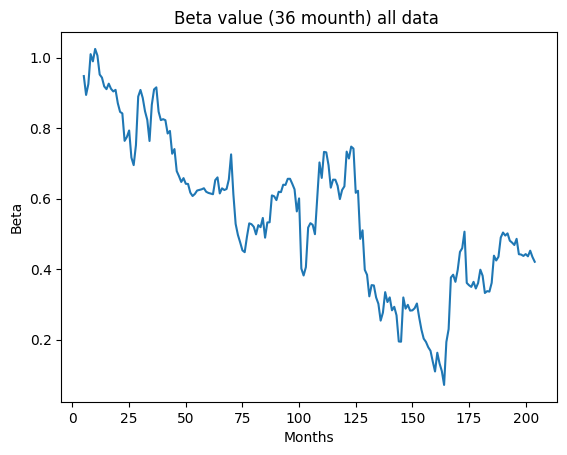

In [16]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')
plt.savefig(f'all_data{COMPANY}.png')

In [17]:
y_test

165    0.193104
166    0.229738
167    0.376168
168    0.384121
169    0.363900
170    0.397603
171    0.448717
172    0.459479
173    0.506249
174    0.360800
175    0.354213
176    0.349426
177    0.363830
178    0.344993
179    0.360402
180    0.398285
181    0.381115
182    0.332207
183    0.337493
184    0.336113
185    0.361009
186    0.438119
187    0.424487
188    0.435114
189    0.489524
190    0.503824
191    0.495191
192    0.501410
193    0.480755
194    0.475212
195    0.468458
196    0.485954
197    0.442308
198    0.441290
199    0.437394
200    0.442580
201    0.436347
202    0.452298
203    0.434282
204    0.420837
Name: target, dtype: float64

In [18]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [19]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'{png_name}.png')
    plt.show()

## Bulding RBF network model

In [20]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 1s 4ms/step - loss: 4.3973
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 3.6702
Epoch 3/200
16/16 [==============================] - 0s 3ms/step - loss: 3.0896
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 2.5809
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 2.1263
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 1.7218
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 1.3640
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 1.0559
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.8016
Epoch 10/200
16/16 [==============================] - 0s 1ms/step - loss: 0.5899
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4172
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2835
Epoch 13/200
16/16 [=================

2/2 [==============================] - 0s 0s/step


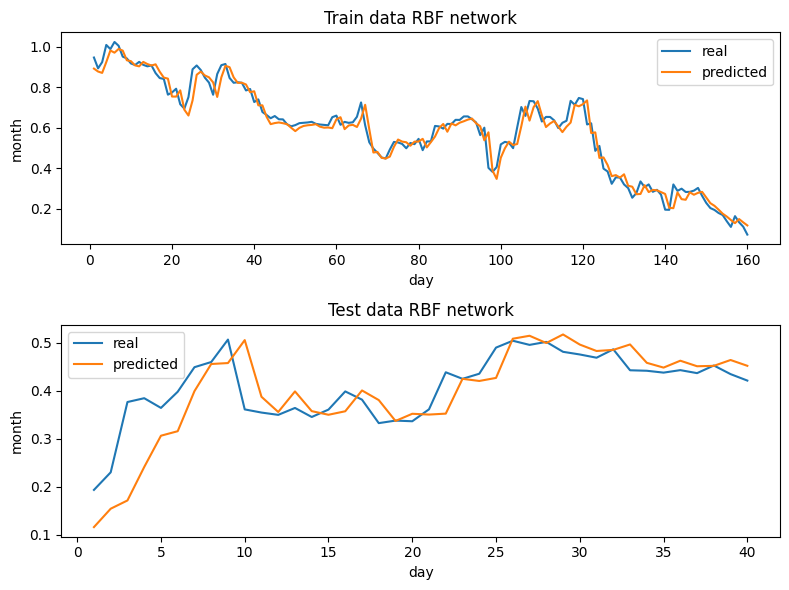

In [21]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', True, f'RBF_{COMPANY}')

In [22]:
import matplotlib.pyplot as plt

def score_table(y_train, y_pred_train, y_test, y_pred_test, title):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    # Tworzenie tabeli
    data = {'data': ['train', 'test'],
            'MSE': [round(mse_train, 3), round(mse_test, 3)],
            'MAE': [round(mae_train, 3), round(mae_test, 3)],
            'R^2': [round(r2_train, 3), round(r2_test, 3)]
            }

    df = pd.DataFrame(data)

    # Tworzenie wykresu tabeli
    fig, ax = plt.subplots()  # Ustalenie rozmiaru wykresu
    ax.axis('off')  # Wyłączenie osi

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    # Zapisywanie tabeli jako obraz PNG
    plt.savefig(f'tabela{title}.png', bbox_inches='tight', pad_inches=0.5)
    plt.show()

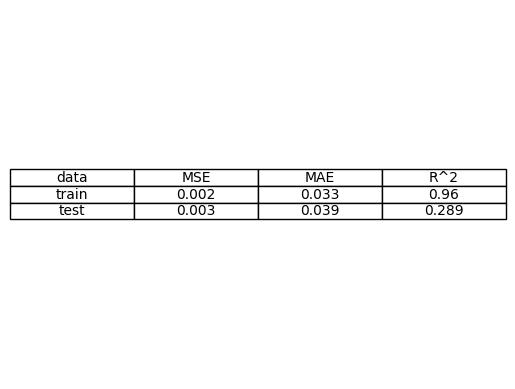

In [23]:
score_table(y_train, y_pred_train, y_test, y_pred_test, f'RBF_{COMPANY}')

## Bulding XGBRegressor model

In [24]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

2/2 [==============================] - 0s 0s/step


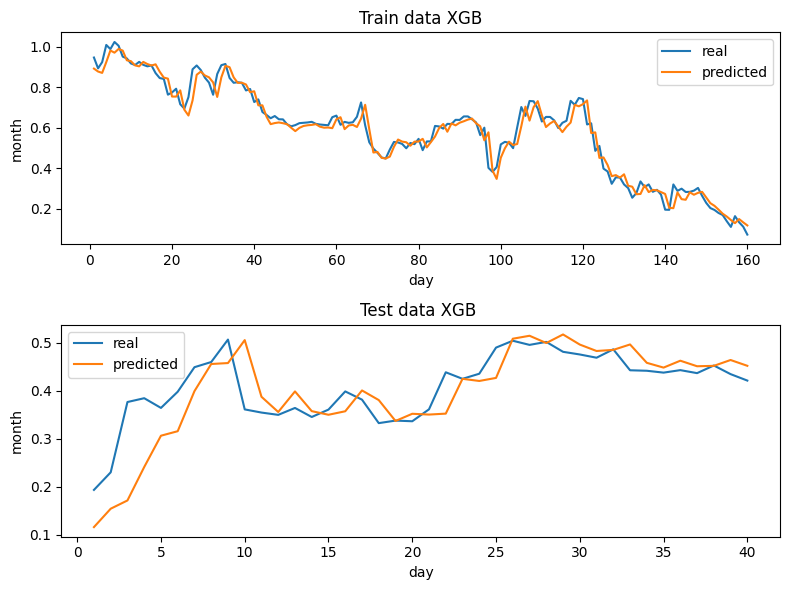

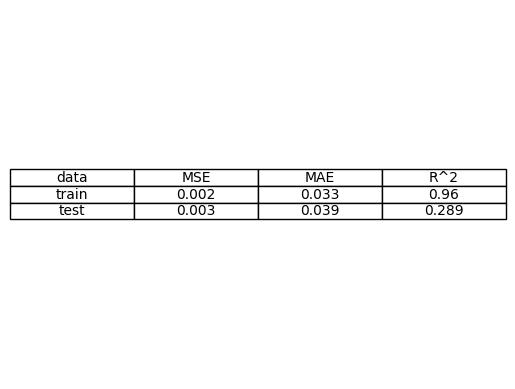

In [25]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data XGB', 'Test data XGB ', True, f'XGB_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'XGB_table_{COMPANY}')

## Bulding LSTM network

In [26]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=20)

Epoch 1/20
160/160 [==============================] - 5s 6ms/step - loss: 0.0286
Epoch 2/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0117
Epoch 3/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0135
Epoch 4/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0120
Epoch 5/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0096
Epoch 6/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0084
Epoch 7/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 8/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0087
Epoch 9/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0086
Epoch 10/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0064
Epoch 11/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0071
Epoch 12/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 13/20
160/160 [====

2/2 [==============================] - 1s 0s/step


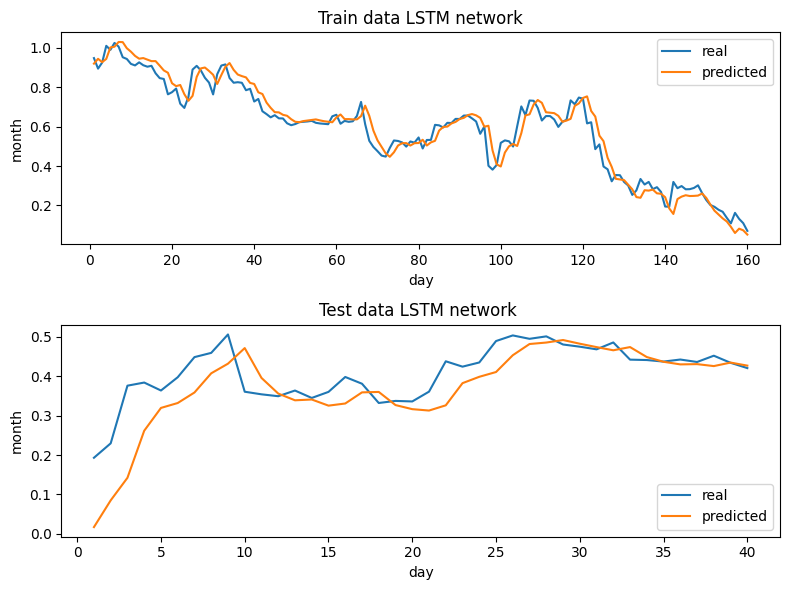

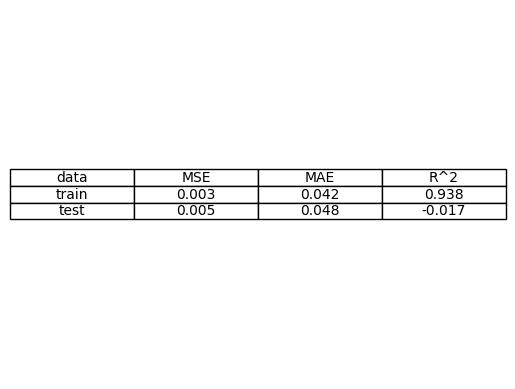

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LSTM network', 'Test data LSTM network ', True, f'LSTM_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LSTM_table_{COMPANY}')

## Bulding Linear regression model

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

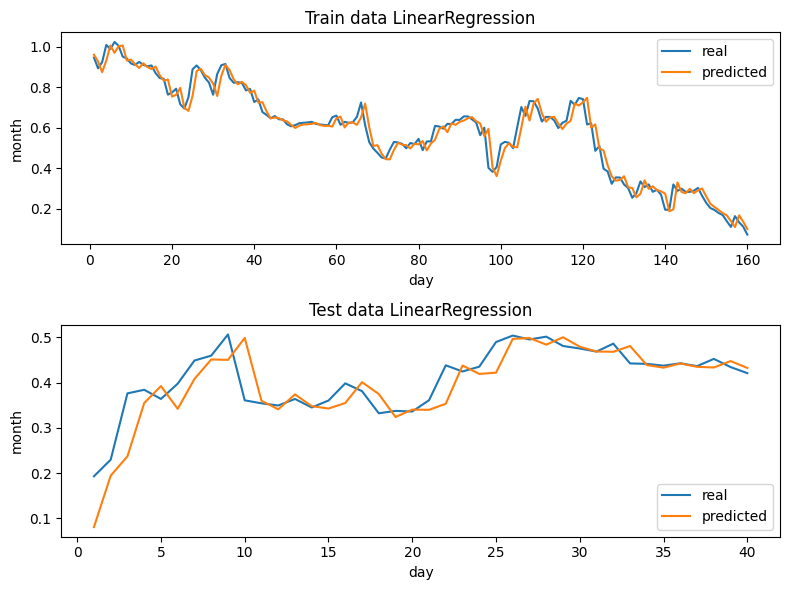

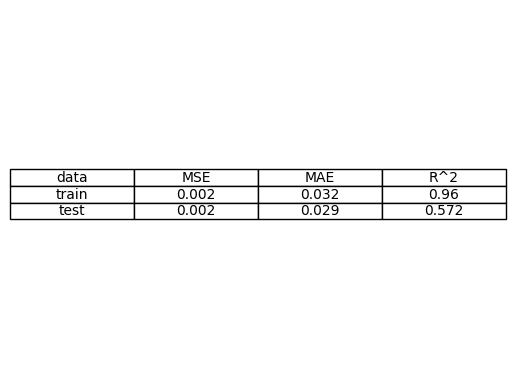

In [30]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data LinearRegression', 'Test data LinearRegression', True, f'LinearRegression_{COMPANY}')
score_table(y_train, y_pred_train, y_test, y_pred_test, f'LinearRegression_{COMPANY}')